# 1. Setup

#### Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import json
import re
from dataclasses import dataclass

#### Define Classes

In [2]:
@dataclass
class tNetConfig:
    num_vars: int
    embedding_size: int

class tNet(nn.Module):
    def __init__(self, config: tNetConfig):
        super(tNet, self).__init__()

        self.config = config
        self.num_vars = config.num_vars
        self.n_embd = config.embedding_size

        self.activation_func = F.relu

        self.conv1 = nn.Conv1d(self.num_vars + 1, self.n_embd, 1)
        self.conv2 = nn.Conv1d(self.n_embd, 2 * self.n_embd, 1)
        self.conv3 = nn.Conv1d(2 * self.n_embd, 4 * self.n_embd, 1)

        self.fc1 = nn.Linear(4 * self.n_embd, 2 * self.n_embd)
        self.fc2 = nn.Linear(2 * self.n_embd, self.n_embd)

        self.input_batch_norm = nn.GroupNorm(1, self.num_vars + 1)

        self.bn1 = nn.GroupNorm(1, self.n_embd)
        self.bn2 = nn.GroupNorm(1, 2 * self.n_embd)
        self.bn3 = nn.GroupNorm(1, 4 * self.n_embd)
        self.bn4 = nn.GroupNorm(1, 2 * self.n_embd)
        self.bn5 = nn.GroupNorm(1, self.n_embd)

    def forward(self, x):
        """
        :param x: [batch, #features + 1, #points]
        :return: logit: [batch, embedding_size]
        """
        x = self.input_batch_norm(x)
        x = self.activation_func(self.bn1(self.conv1(x)))
        x = self.activation_func(self.bn2(self.conv2(x)))
        x = self.activation_func(self.bn3(self.conv3(x)))
        x, _ = torch.max(x, dim=2)  # global max pooling
        assert x.size(1) == 4 * self.n_embd

        x = self.activation_func(self.bn4(self.fc1(x)))
        x = self.activation_func(self.bn5(self.fc2(x)))

        return x

class TextDiffusionModel:
    def __init__(self, vocab_size, seq_len, device="cpu"):
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.device = device
        # self.noise_schedule = torch.linspace(0.01, 0.1, steps=1000).to(device)  # Noise variance per timestep
        self.noise_schedule = torch.linspace(1e-4, 2e-2, steps=1000).to(device)  # Noise variance per timestep

    def add_noise(self, tokens, t):
        noise_std = self.noise_schedule[t].view(-1, 1, 1)  # Shape: (batch_size, 1, 1)

        # Convert tokens to one-hot vectors
        one_hot = F.one_hot(tokens.long(), num_classes=self.vocab_size).float()
        
        # Add Gaussian noise to the one-hot vectors
        noise = torch.randn_like(one_hot) * noise_std
        noisy_one_hot = one_hot + noise

        # Compute softmax to normalize the noisy one-hot vectors
        noisy_tokens = F.softmax(noisy_one_hot, dim=-1)
        return noisy_tokens, noise

    def sample_from_noisy_tokens(self, noisy_tokens):
        sampled_tokens = torch.argmax(noisy_tokens, dim=-1)
        return sampled_tokens

class ReverseProcessModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_vars, seq_len):
        super(ReverseProcessModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.num_vars = num_vars
        self.seq_len = seq_len

        # Calculate the correct input size for fc1
        input_size = embedding_size + (seq_len * vocab_size) + 1  # embeddings + noisy_tokens + timestep

        # Define layers for the reverse process model
        self.fc1 = nn.Linear(input_size, 512)  # Adjusted input size
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, seq_len * vocab_size)  # Output for all tokens in the sequence

    def forward(self, noisy_tokens, embeddings, t):
        # Flatten noisy tokens to [batch_size, seq_len * vocab_size]
        noisy_tokens_flat = noisy_tokens.view(noisy_tokens.size(0), -1)

        # Concatenate embeddings, flattened noisy tokens, and timestep information
        timestep_embedding = torch.cat([embeddings, noisy_tokens_flat, t.unsqueeze(1).float()], dim=-1)
        
        # Pass through the fully connected layers
        x = F.relu(self.fc1(timestep_embedding))
        x = F.relu(self.fc2(x))
        predicted_noise = self.fc3(x)

        # Reshape to [batch_size, seq_len, vocab_size]
        predicted_noise = predicted_noise.view(-1, self.seq_len, self.vocab_size)
        
        return predicted_noise

# 2. Tokenize Formula

In [3]:
# Define a function to tokenize a formula
def tokenize_formula(formula):
    token_pattern = r"[a-zA-Z_][a-zA-Z0-9_]*|[()+\-*/]|\d+\.?\d*"
    tokens = re.findall(token_pattern, formula)
    return tokens

In [4]:
# Define the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

folder_path = "data_symbolic_regression/train"
val_folder_path = "data_symbolic_regression/val"

# Load and tokenize formulas from the training set; Convert the data points to a Pytorch tensor
tokenized_formulas = []
points_list = []

for file_name in os.listdir(folder_path):
    if file_name.endswith(".json") and not file_name.startswith('properties'):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, "r") as file:
            data = json.load(file)

            formula_human_readable = data.get("formula_human_readable", "")
            if formula_human_readable:
                tokens = tokenize_formula(formula_human_readable)
                tokenized_formulas.append(tokens)
            
            points = data.get("points")
            if points:
                points_array = np.array([points["var_0"], points["var_1"], points["var_2"], points["target"]])
                points_tensor = torch.tensor(points_array, dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dimension
                points_list.append(points_tensor)

val_tokenized_formulas = []
val_points_list = []

# Create the vocabulary from the tokens
for file_name in os.listdir(val_folder_path):
    if file_name.endswith(".json") and not file_name.startswith('properties'):
        file_path = os.path.join(val_folder_path, file_name)
        with open(file_path, "r") as file:
            val_data = json.load(file)

            val_formula_human_readable = val_data.get("formula_human_readable", "")
            if val_formula_human_readable:
                val_tokens = tokenize_formula(val_formula_human_readable)
                val_tokenized_formulas.append(val_tokens)
            
            val_points = val_data.get("points")
            if val_points:
                val_points_array = np.array([val_points["var_0"], val_points["var_1"], val_points["var_2"], val_points["target"]])
                val_points_tensor = torch.tensor(val_points_array, dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dimension
                val_points_list.append(val_points_tensor)

all_tokenized_formulas = tokenized_formulas + val_tokenized_formulas

In [5]:
vocab_mapping = {token: idx for idx, token in enumerate(set(t for tokens in all_tokenized_formulas for t in tokens))}
vocab_size = len(vocab_mapping)

# Define EOS and PAD token IDs
eos_token_id = vocab_size  # Assuming the last ID in the vocabulary is for EOS
pad_token_id = vocab_size + 1  # Assuming the second-to-last ID in the vocabulary is for PAD

# Add EOS and PAD tokens to vocab_mapping if not already present
if eos_token_id not in vocab_mapping.values():
    vocab_mapping['<EOS>'] = eos_token_id
if pad_token_id not in vocab_mapping.values():
    vocab_mapping['<PAD>'] = pad_token_id

vocab_size = len(vocab_mapping)

In [6]:
# Tokenize and map tokens to vocabulary indices
token_sequences = [[vocab_mapping.get(token, pad_token_id) for token in tokens] for tokens in tokenized_formulas]

# Calculate sequence length based on the 95th percentile of formula lengths
formula_lengths = [len(tokens) for tokens in tokenized_formulas]
seq_len = int(np.percentile(formula_lengths, 100)) + 1 # Use 95th percentile
batch_size = 100  # Example batch size

# Pad or truncate sequences to seq_len, adding EOS token last
token_sequences = [
    seq[:seq_len] + [eos_token_id] + [pad_token_id]*max(0, seq_len - len(seq)) 
    if len(seq) < seq_len else seq[:seq_len] + [eos_token_id]  # Add EOS token at the end after padding
    for seq in token_sequences
]

# Convert to tensor
token_tensor = torch.tensor(token_sequences, device=device)

# Pad or truncate sequences to seq_len
token_sequences = [seq[:seq_len] + [0] * max(0, seq_len - len(seq)) for seq in token_sequences]
token_tensor = torch.tensor(token_sequences, device=device)

In [7]:
# Tokenize and map tokens to vocabulary indices
val_token_sequences = [[vocab_mapping.get(token, pad_token_id) for token in tokens] for tokens in val_tokenized_formulas]

# Calculate sequence length based on the 95th percentile of formula lengths
val_formula_lengths = [len(tokens) for tokens in val_tokenized_formulas]
val_seq_len = int(np.percentile(val_formula_lengths, 100))  # Use 95th percentile

# Pad or truncate sequences to seq_len, adding EOS token last
val_token_sequences = [
    seq[:seq_len] + [eos_token_id] + [pad_token_id]*max(0, seq_len - len(seq)) 
    if len(seq) < seq_len else seq[:seq_len] + [eos_token_id]  # Add EOS token at the end after padding
    for seq in val_token_sequences
]

# Convert to tensor
val_token_tensor = torch.tensor(val_token_sequences, device=device)

# Pad or truncate sequences to seq_len
val_token_sequences = [seq[:seq_len] + [0] * max(0, seq_len - len(seq)) for seq in val_token_sequences]
val_token_tensor = torch.tensor(val_token_sequences, device=device)

# 3. Preprocessing Data

In [8]:
# Initialize the model
diffusion_model = TextDiffusionModel(vocab_size, seq_len, device=device)

# Choose random timesteps for each sequence
t = torch.randint(0, 1000, (len(token_tensor),), device=device)

# Add noise to the tokens
noisy_tokens, noise = diffusion_model.add_noise(token_tensor, t)

# Sample from noisy tokens
sampled_tokens = diffusion_model.sample_from_noisy_tokens(noisy_tokens)

# Configuration for tNet
num_vars = 3
embedding_size = 128  # Example embedding size
config = tNetConfig(num_vars=num_vars, embedding_size=embedding_size)

# Instantiate the model
tnet_model = tNet(config)

# Input: batch_size x (num_vars + 1) x num_points
batch_size = 1

# Generate embeddings
# input_tensor = torch.rand(batch_size, num_vars, 100)

output_embeddings = []
for pt in points_list:
    output_embedding = tnet_model(pt)
    output_embeddings.append(output_embedding)

points_tensors = torch.cat(points_list, dim=0)

output_embeddings_tensor = torch.cat(output_embeddings, dim=0)
# Print the output
print("Input shape:", points_tensors.shape)
print("Output shape:", output_embeddings_tensor.shape)

# Print results
print("Original Tokens shape:", token_tensor.shape)
print("Noisy Tokens (probabilities) shape:", noisy_tokens.shape)
print("Sampled Tokens shape:", sampled_tokens.shape)


Input shape: torch.Size([747, 4, 100])
Output shape: torch.Size([747, 128])
Original Tokens shape: torch.Size([747, 28])
Noisy Tokens (probabilities) shape: torch.Size([747, 28, 25])
Sampled Tokens shape: torch.Size([747, 28])


# 4. Training and Validation Loop

In [9]:
# Initialize reverse model (denoiser)
reverse_model = ReverseProcessModel(vocab_size, embedding_size, num_vars, seq_len).to(device)

# Cross-entropy loss function
loss_fn = nn.CrossEntropyLoss()

# Train the reverse process model
epochs = 1000  # Define the number of epochs for training
batch_size = 100  # Example batch size

# Optimizer for the reverse process model
optimizer = torch.optim.Adam(reverse_model.parameters(), lr=1e-4)
#optimizer = torch.optim.AdamW(reverse_model.parameters(), lr=1e-4, weight_decay=0.01)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=2,factor=0.5)

# Early stopping parameters
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

# Initialize lists to store training and validation losses
training_losses = []
validation_losses = []

In [10]:
# Training loop
for epoch in range(epochs):
    reverse_model.train()
    total_loss = 0

    # Training Phase
    for batch_idx in range(0, len(points_list), batch_size):
        batch_points = points_list[batch_idx:batch_idx + batch_size]
        batch_token_tensor = token_tensor[batch_idx:batch_idx + batch_size]

        # Random timesteps
        t_batch = torch.randint(0, 1000, (len(batch_points),), device=device)

        # Add noise
        noisy_tokens, _ = diffusion_model.add_noise(batch_token_tensor, t_batch)

        # Get embeddings
        batch_embeddings = [tnet_model(pt) for pt in batch_points]
        embeddings_tensor = torch.cat(batch_embeddings, dim=0)

        # Predict logits
        logits = reverse_model(noisy_tokens, embeddings_tensor, t_batch)

        # Reshape logits and target tokens for CrossEntropyLoss
        logits_flat = logits.view(-1, vocab_size)
        target_tokens = batch_token_tensor.view(-1)

        # Compute loss
        loss = loss_fn(logits_flat, target_tokens)
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation Phase
    reverse_model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_batch_idx in range(0, len(val_points_list), batch_size):
            val_batch_points = val_points_list[val_batch_idx:val_batch_idx + batch_size]
            val_batch_token_tensor = val_token_tensor[val_batch_idx:val_batch_idx + batch_size]

            val_t_batch = torch.randint(0, 1000, (len(val_batch_points),), device=device)

            val_noisy_tokens, _ = diffusion_model.add_noise(val_batch_token_tensor, val_t_batch)

            val_embeddings = [tnet_model(pt) for pt in val_batch_points]
            val_embeddings_tensor = torch.cat(val_embeddings, dim=0)

            val_logits = reverse_model(val_noisy_tokens, val_embeddings_tensor, val_t_batch)
            val_logits_flat = val_logits.view(-1, vocab_size)
            val_target_tokens = val_batch_token_tensor.view(-1)

            val_loss += loss_fn(val_logits_flat, val_target_tokens).item()

    val_loss /= len(val_points_list)

    # Store losses for plotting
    training_losses.append(total_loss / len(points_list))
    validation_losses.append(val_loss)

    # Print progress
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {training_losses[-1]:.4f}, Val Loss: {val_loss:.4f}")

    #scheduler.step(val_loss)
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(reverse_model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered. Restoring best model...")
        reverse_model.load_state_dict(torch.load('best_model.pth'))
        break

Epoch [1/1000], Loss: 0.0427, Val Loss: 0.0412
Epoch [2/1000], Loss: 0.0314, Val Loss: 0.0327
Epoch [3/1000], Loss: 0.0264, Val Loss: 0.0295
Epoch [4/1000], Loss: 0.0240, Val Loss: 0.0270
Epoch [5/1000], Loss: 0.0219, Val Loss: 0.0252
Epoch [6/1000], Loss: 0.0206, Val Loss: 0.0237
Epoch [7/1000], Loss: 0.0199, Val Loss: 0.0239
Epoch [8/1000], Loss: 0.0194, Val Loss: 0.0219
Epoch [9/1000], Loss: 0.0187, Val Loss: 0.0214
Epoch [10/1000], Loss: 0.0182, Val Loss: 0.0209
Epoch [11/1000], Loss: 0.0180, Val Loss: 0.0210
Epoch [12/1000], Loss: 0.0178, Val Loss: 0.0206
Epoch [13/1000], Loss: 0.0172, Val Loss: 0.0203
Epoch [14/1000], Loss: 0.0169, Val Loss: 0.0196
Epoch [15/1000], Loss: 0.0168, Val Loss: 0.0198
Epoch [16/1000], Loss: 0.0164, Val Loss: 0.0191
Epoch [17/1000], Loss: 0.0162, Val Loss: 0.0192
Epoch [18/1000], Loss: 0.0161, Val Loss: 0.0189
Epoch [19/1000], Loss: 0.0161, Val Loss: 0.0188
Epoch [20/1000], Loss: 0.0160, Val Loss: 0.0187
Epoch [21/1000], Loss: 0.0159, Val Loss: 0.0187
E

C:\Users\matth\AppData\Local\Temp\ipykernel_44040\3912563837.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reverse_model.load_state_dict(torch.load('best_model.pth'))

# 5. Results and Exploratory Data Analysis

In [16]:
import matplotlib.pyplot as plt

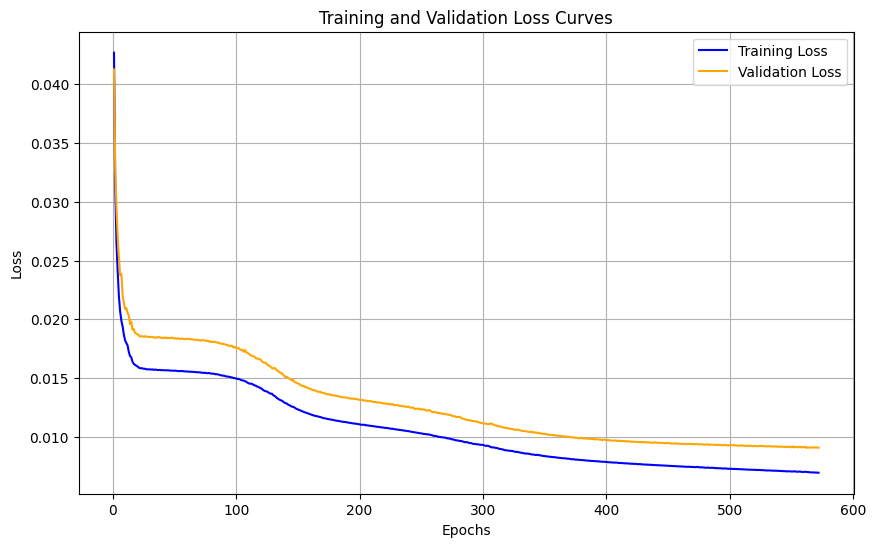

In [17]:
    
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# 6. Evaluate Model

In [18]:
import torch
import os
import json
import numpy as np
from sklearn.metrics import accuracy_score

In [19]:
def evaluate_diffusion_model(test_folder, diffusion_model, reverse_model, tnet_model, vocab_mapping, seq_len, device):
    reverse_vocab_mapping = {idx: token for token, idx in vocab_mapping.items()}

    results = []

    for file_name in os.listdir(test_folder):
        if file_name.endswith(".json") and not file_name.startswith('properties'):
            file_path = os.path.join(test_folder, file_name)

            with open(file_path, "r") as file:
                data = json.load(file)

                formula_human_readable = data.get("formula_human_readable", "")
                tokens = tokenize_formula(formula_human_readable)

                # Convert tokens to indices
                token_indices = [vocab_mapping.get(token, 0) for token in tokens]

                # Pad or truncate to seq_len
                token_indices = token_indices[:seq_len] + [0] * max(0, seq_len - len(token_indices))
                token_tensor = torch.tensor(token_indices, device=device).unsqueeze(0)  # Add batch dimension

                points = data.get("points")
                if points:
                    points_array = np.array([points["var_0"], points["var_1"], points["var_2"], points["target"]])
                    points_tensor = torch.tensor(points_array, dtype=torch.float32, device=device).unsqueeze(0)

                    # Generate embeddings using tNet model
                    embedding = tnet_model(points_tensor)

                    # Choose random timestep
                    t = torch.randint(0, 1000, (1,), device=device)

                    # Add noise to the tokens
                    noisy_tokens, _ = diffusion_model.add_noise(token_tensor, t)

                    # Use reverse model to reconstruct the clean tokens
                    reconstructed_noise = reverse_model(noisy_tokens, embedding, t)
                    # print(f"Reconstructed Noise Shape: {reconstructed_noise.shape}")
                    # Convert reconstructed noise to token indices
                    # reconstructed_tokens = torch.argmax(reconstructed_noise, dim=-1).squeeze(0)

                    # Ensure reconstructed_tokens is a list
                    reconstructed_tokens = torch.argmax(reconstructed_noise, dim=-1)
                    # print(reconstructed_tokens)
                    if reconstructed_tokens.dim() == 2:  # Case: (batch_size, seq_len)
                        reconstructed_tokens = reconstructed_tokens.squeeze(0)  # Remove batch dimension
                    elif reconstructed_tokens.dim() == 1:  # Case: (seq_len,)
                        pass  # Already correct
                    else:
                        raise ValueError(f"Unexpected shape for reconstructed_tokens: {reconstructed_tokens.shape}")

                    # print(reconstructed_tokens)
                    # Map token indices back to tokens
                    reconstructed_formula = "".join(
                        reverse_vocab_mapping[idx] if idx in reverse_vocab_mapping else "<UNK>" for idx in reconstructed_tokens.tolist()
                    )
                    
                    reconstructed_formula = reconstructed_formula.replace("<EOS>", "").replace("<PAD>", "")
                    
                    actual_formula = "".join(tokens)

                    results.append((actual_formula, reconstructed_formula))
    return results

In [38]:

# Define the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

folder_path_test = "data_symbolic_regression/test"

# Load and tokenize formulas from the training set; Convert the data points to a Pytorch tensor
tokenized_formulas_test = []
points_list_test = []

for file_name in os.listdir(folder_path_test):
    if file_name.endswith(".json") and not file_name.startswith('properties'):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, "r") as file:
            data = json.load(file)

            formula_human_readable_test = data.get("formula_human_readable", "")
            if formula_human_readable_test:
                tokens_test = tokenize_formula(formula_human_readable_test)
                tokenized_formulas_test.append(tokens_test)
                
            points_test = data.get("points")
            if points_test:
                points_array_test = np.array([points_test["var_0"], points_test["var_1"], points_test["var_2"], points_test["target"]])
                points_tensor_test = torch.tensor(points_array_test, dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dimension
                points_list_test.append(points_tensor_test)

# Evaluate the model
results = evaluate_diffusion_model(folder_path_test, diffusion_model, reverse_model, tnet_model, vocab_mapping, seq_len, device)

# Display example results
example_idx = 11

if results:
    actual, reconstructed = results[example_idx]
    print(f"Actual Formula: {actual}")
    print(f"Reconstructed Formula: {reconstructed}")

Actual Formula: (((var_2*C_0)*cos(var_1))*gaussian(reverse(var_0)))
Reconstructed Formula: (((var_0+C_0)+sqrt(var_1)))gaussian(((var_2)))
